In [31]:
%config IPCompleter.greedy=True
from queue import *
import sys

In [32]:
disjointsets = []
disjointpreclumps = []

class IndependentSet():
    def __init__(self, g):
        self.G = g
        self.Forest = Graph(g.order())

    def I(self):
        return self.Forest.edges()

In [33]:
# https://medium.com/100-days-of-algorithms/day-41-union-find-d0027148376d
def find(data, i):
    if i != data[i]:
        data[i] = find(data, data[i])
    return data[i]

def union(data, i, j):
    pi, pj = find(data, i), find(data, j)
    if pi != pj:
        data[pi] = pj

In [34]:
def rootTree(self, root, I):
    d = DiGraph()
    q = Queue()
    q.put(root)
    levelordernumber = 0
    
    while not q.empty():
        v = q.get()
        levelordernumber += 1
        I.Levelordernumbers[v] = levelordernumber
        I.Visited[v] = True
        I.Treenumbers[v] = root
        
        for n in self.neighbor_iterator(v):
            if not I.Visited[n]:
                d.add_edge(v,n)
                q.put(n)
                
    return d
        
Graph.rootTree = rootTree

In [174]:
def c_graphic((a,b), I):
    if I.Treenumbers[a] != I.Treenumbers[b]:
        return None
    
    global disjointsets
    cycle = []
    tree = I.Trees[I.Treenumbers[a]]
    while a != b:
        node = a if I.Levelordernumbers[a] > I.Levelordernumbers[b] else b
        parent = tree.neighbors_in(node)[0]
        #print ("node: " + str(node))
        #print ("parent: " + str(parent))
        if find(disjointsets, parent) != find(disjointsets, node):
            #print ("cycle append")
            cycle.append((parent,node) if parent < node else (node,parent))
            union(disjointsets, parent, node)
        if I.Levelordernumbers[a] > I.Levelordernumbers[b]:
            a = parent
        else:
            b = parent
    
    return cycle

In [175]:
def start_graphic(Is):
    global disjointsets
    disjointsets = [i for i in range(Is[0].Forest.order())]
    for I in Is:
        I.Treenumbers = [0] * I.Forest.order()
        I.Trees = [DiGraph() for i in range(Is[0].Forest.order())]
        I.Levelordernumbers = [0] * I.Forest.order()
        I.Visited = [False] * I.Forest.order()
        components = I.Forest.connected_components_subgraphs()
        for c in components:
            root = c.vertices()[0]
            rootedTree = c.rootTree(root, I)
            I.Trees[root] = rootedTree

In [176]:
def cyclic_scanning(e, k, labels, Is, c):
    q = Queue()
    q.put(e)
    while not q.empty():
        e = q.get()
        (_,i) = labels[e]
        i = (i + 1) % k
        cycle = c(e, Is[i])
        #print ("cycle " + str(i))
        #print (cycle)
        if cycle == None:
            return ((e,i), labels)
        for f in cycle:
            labels[f] = (e, i)
            q.put(f)
    return (None, labels)

In [177]:
def update_partitioned_independentset(Is, k, label, labels):
    if label != None:
        (f,i) = label
        while i != -1:
            Is[i].Forest.add_edge(f + (i,))
            if f != e:
                i = (i - 1) % k
                Is[i].Forest.delete_edge(f + (i,))
            (f,i) = labels[f]

In [178]:
def k_forest(g, k, start, c):
    Is = [IndependentSet(g) for i in range(k)]
    
    removedEdges = []
    for v in filter(lambda v: g.degree(v) <= k, g.vertices()):
        for idx, e in enumerate(g.edges_incident([v], labels = False)):
            removedEdges.append(e + (idx,))
        g.delete_vertex(v)
    
    start(Is)
    
    label = None
    for e in g.edges(labels = False):
        labels = {}
        labels[e] = (e,-1)
        if label != None:
            start(Is)
        (label, labels) = cyclic_scanning(e, k, labels, Is, c)
        update_partitioned_independentset(Is, k, label, labels)
    
    for (a, b, idx) in removedEdges:
        Is[idx].Forest.add_edge((a, b, idx))
        g.add_edge((a, b))  
        
    return Is

In [179]:
def top_clump(Is, start, c):
    L = []
    B = sum([I.I() for I in Is], [])
    for e in B:
        start(Is)
        labels = {}
        labels[e[:2]] = (e,-1)
        (label, labels) = cyclic_scanning(e[:2], len(Is), labels, Is, c)
        if label == None:
            L.append(e)
    return L

In [180]:
def c_dual((a,b), I):
    global disjointsets
    cycle = []
    mincut = I.G.edge_cut(a, b, value_only=False, use_edge_labels = True)[1]
    mincut = [(x,y) for (x,y,_) in mincut if (x,y) in I.J]
    if mincut == []:
        return None
    for (a,b) in mincut:
        if find(disjointsets, a) != find(disjointsets, b):
            cycle.append((a, b))
            union(disjointsets, a, b)
    return cycle

In [181]:
def start_dual(Is):
    global disjointsets
    disjointsets = [i for i in range(Is[0].Forest.order())]
    m = Matroid(Is[0].G)
    for I in Is:
        span = m.closure([e[:2] for e in I.Forest.edges()])
        forest_edges = map(lambda z: z[:2], I.Forest.edges())
        I.J = [(x,y) for (x,y) in span if (x,y) not in forest_edges]

In [182]:
def top_clump_dual(Is, start, c, start_dual, c_dual):
    A = []
    B = sum([I.I() for I in Is], [])
    k = len(Is)
    start(Is)
    for i in range(k):
        for e in Is[i].I():
            for j in range(i + 1, i + k):
                j = j % k
                if c(e[:2], Is[j]) == None:
                    A.append(e[:2])
                    break
    start_dual(Is)
    labels = {}
    for e in A: labels[e] = (e,-1)
    for e in A: (label, labels) = cyclic_scanning(e, k, labels, Is, c_dual)
    return filter(lambda x: x[:2] not in labels.keys(), B)

14


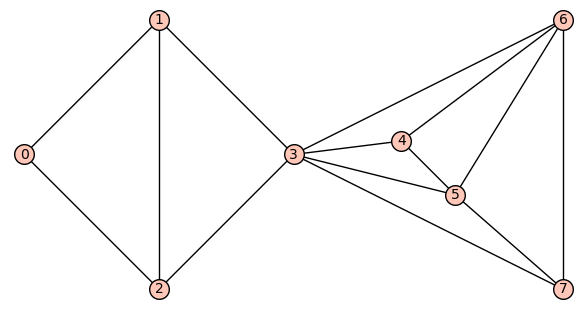

13


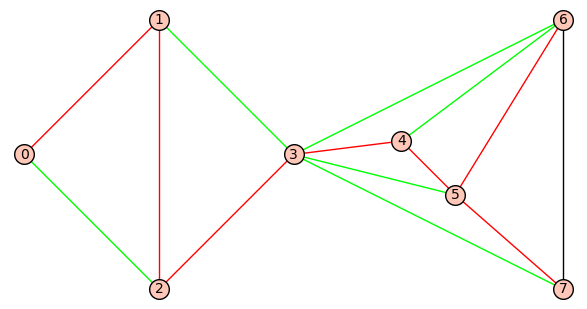

In [286]:
graph = Graph(8) #Graph({0: [1], 1: [2,3], 3: [4,5]})
graph.add_edge(0,1)
graph.add_edge(0,2)
graph.add_edge(1,2)
graph.add_edge(2,3)
graph.add_edge(1,3)
graph.add_edge(3,6)
graph.add_edge(3,4)
graph.add_edge(3,5)
graph.add_edge(3,7)
graph.add_edge(4,5)
graph.add_edge(5,7)
graph.add_edge(4,6)
graph.add_edge(5,6)
graph.add_edge(7,6)
pos = {0:[0.0, 0.0], 1:[1.0, 1.0], 2:[1.0, -1.0], 3:[2.0, 0.0], 4:[2.8, 0.1], 5:[3.2, -0.3], 6:[4.0, 1.0], 7:[4.0, -1.0]}


#graph = Graph(4) #Graph({0: [1], 1: [2,3], 3: [4,5]})
#graph.add_edge(0,1)
#graph.add_edge(0,2)
#graph.add_edge(0,3)
#graph.add_edge(2,3)
#graph.add_edge(1,3)
#pos = {0:[0.0, 0.0], 1:[1.0, 1.0], 2:[1.0, -1.0], 3:[2.0, 0.0]}

#graph = graphs.CycleGraph(9)
#pos = graph.layout().copy()

#graph = graphs.PoussinGraph()
#pos = graph.layout()

#graph = graphs.FruchtGraph()
#pos = graph.layout()

#graph = graphs.GoldnerHararyGraph()
#graph.delete_edge((1,3,None))
#pos = graph.layout()

#graph = graphs.HerschelGraph()
#pos = graph.layout()

#graph = graphs.WienerArayaGraph()
#pos = graph.layout()

#graph = graphs.CompleteGraph(5)
#pos = graph.layout()

graph.weighted(True)

print (len(graph.edges()))
p = graph.plot(vertex_labels=True, pos=pos)
p.show()

Is = k_forest(graph, 2, start_graphic, c_graphic)
l1 = Is[0].I()
l2 = Is[1].I()
l = l1 + l2
print(len(l))
res1 = set(map(lambda x: x[:2], graph.edges()))
res2 = set(map(lambda x: x[:2], l))
res = res1.difference(res2)
r = map(lambda x: x + (-1,), list(res))
output = Graph(4)
output.add_edges(r + l)
pp = output.plot(vertex_labels=True, color_by_label={0:(1,0,0), 1:(0,1,0)}, pos=pos)
pp.show()

8


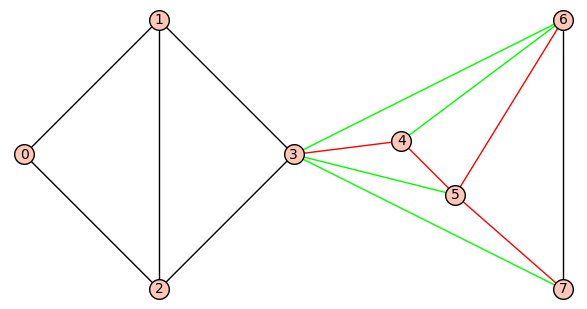

In [283]:

L = top_clump(Is, start_graphic, c_graphic)
print(len(L))
res1 = set(map(lambda x: x[:2], graph.edges()))
res2 = set(map(lambda x: x[:2], L))
res = res1.difference(res2)
r = map(lambda x: x + (-1,), list(res))
gg = Graph({})
gg.add_edges(r + L)
p = gg.plot(vertex_labels=True, color_by_label={0:(1,0,0), 1:(0,1,0)}, pos=pos)
p.show()

8


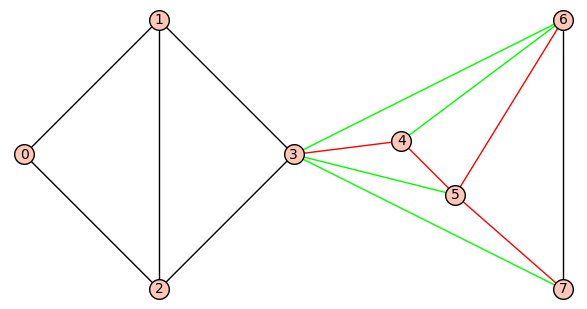

In [284]:
L = top_clump_dual(Is, start_graphic, c_graphic, start_dual, c_dual)
print(len(L))
res1 = set(map(lambda x: x[:2], graph.edges()))
res2 = set(map(lambda x: x[:2], L))
res = res1.difference(res2)
r = map(lambda x: x + (-1,), list(res))
ggg = Graph({})
ggg.add_edges(r + L)
p = ggg.plot(vertex_labels=True, color_by_label={0:(1,0,0), 1:(0,1,0)}, pos=pos)
p.show()


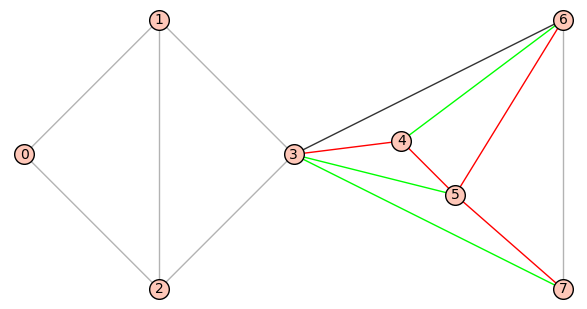

In [281]:
pp = {0:[0.0, 0.0], 1:[1.0, 1.0], 2:[1.0, -1.0], 3:[2.0, 0.0], 4:[2.8, 0.1], 5:[3.2, -0.3], 6:[4.0, 1.0], 7:[4.0, -1.0]}
preclumpedges = [(0,1,2), (0,2,2), (1,2,2),(1,3,2),(2,3,2),(3,6,3),(3,5,1),(3,7,1),(4,6,1),(3,4,0),(4,5,0),(5,6,0),(5,7,0),(6,7,2)]
preclump = Graph(8)
preclump.add_edges(preclumpedges)
p = preclump.plot(vertex_labels=True, color_by_label={0:(1,0,0), 1:(0,1,0), 2:(0.7,0.7,0.7), 3:(0.2,0.2,0.2)}, pos=pp)
p.show()

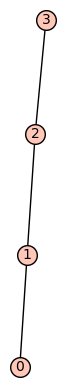

In [264]:
g = Graph(4)
#g.add_edge(0,1)
#g.add_edge(0,3)
#g.add_edge(1,2)
#g.add_edge(0,2)
#g.add_edge(2,3)

g.add_edge(0,1)
g.add_edge(1,2)
g.add_edge(2,3)


#print (g.vertices())
#y = map(lambda x: x[:2], g.edges())
#z = map(lambda x: x + (-2,), list(y))
#print (z)
#print (g.edges())
g.plot()
#print(graph.edges())
#x = graph.edge_cut(0, 1, value_only=False, use_edge_labels = True)[1]
#print(x)
#w = [(a,b) for (a,b,_) in x if (a,b) not in [(0,1)]]
#print(w)

In [213]:
def is_generic_independent(g):
    if g.size() <= 2 * g.order() - 3:
        Is = k_forest(g, 2, start_graphic, c_graphic)
        if sum([len(I.I()) for I in Is]) == g.size():
            if not top_clump(Is, start_graphic, c_graphic):
                return True
    return False

In [214]:
r = is_generic_independent(graph)
print (r)

False


In [215]:
def preclump_test_step(Is, (u,v)):
    global disjointpreclumps
    global edgeindices
    
    for I in Is:
        preclumpset1 = set()
        preclumpset2 = set()
        forest = I.Forest
        for neighbor in forest.neighbors(u):
            edgeIdx = edgeindices[(neighbor,u) if neighbor < u else (u,neighbor)]
            preclumpset1.add(find(disjointpreclumps, edgeIdx))

        for neighbor in forest.neighbors(v):
            edgeIdx = edgeindices[(neighbor,v) if neighbor < v else (v,neighbor)]
            preclumpset2.add(find(disjointpreclumps, edgeIdx))
            
        if preclumpset1 & preclumpset2 != set(): return true
    return false

In [216]:
def degrees_of_freedom(g):
    global disjointpreclumps
    global edgeindices
    
    k = 2
    disjointpreclumps = [i for i in range(g.size())]
    edgeindices = { e : idx for idx, e in enumerate(g.edges(labels = False)) }
    print (edgeindices)
    Is = [IndependentSet(g) for i in range(k)]
    #print (Is[0].Trees)
    for e in g.edges(labels = False):
        start_graphic(Is)
        # Preclump test step
        if preclump_test_step(Is, e): 
            print ("preclump test step")
            continue         
        
        # Independence Test Step
        labels = {}
        labels[e] = (e,-1)
        
        (label, labels) = cyclic_scanning(e, k, labels, Is, c_graphic)
        update_partitioned_independentset(Is, k, label, labels)
        
        if label != None:
            #print ("B + e ist unabhängig")
            start_graphic(Is)
            #print (Is[0].I())
            #print (Is[1].I())
            labels2 = {}
            labels2[e] = (e,-1)
            (label2, labels2) = cyclic_scanning(e, k, labels2, Is, c_graphic)
            
            if label2 != None:
                #print ("continue")
                continue
            
            print("New Preclump Step")
            print (e)
            (f,i) = label
            while i != -1:
                Is[i].Forest.delete_edge(f + (i,))
                if f != e:
                    i = (i - 1) % k
                    Is[i].Forest.add_edge(f + (i,))
                (f,i) = labels[f]
                
            print (Is[0].I())
            print (Is[1].I())
                
            print("Merge edge partitions")
            fundamental_circuit = labels2.keys()
            fundamental_circuit.remove(e)
            for i in range(len(fundamental_circuit) - 1):
                edgeidx1 = edgeindices[fundamental_circuit[i]]
                edgeidx2 = edgeindices[fundamental_circuit[i + 1]]
                union(disjointpreclumps, edgeidx1, edgeidx2)
                print (disjointpreclumps)
        
    return 2 * g.order() - 3 - len(Is[0].I()) - len(Is[1].I())

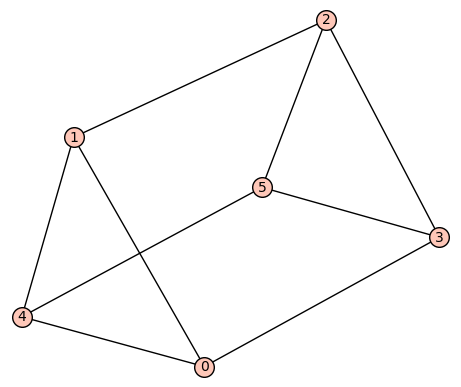

In [218]:
gg = Graph(6)
gg.add_edge(0,1)
gg.add_edge(1,2)
gg.add_edge(2,3)
gg.add_edge(3,0)
gg.add_edge(0,4)
gg.add_edge(1,4)
gg.add_edge(2,5)
gg.add_edge(3,5)
gg.add_edge(4,5)

gg.plot()

In [219]:
degrees_of_freedom(gg)

{(0, 1): 0, (1, 2): 3, (4, 5): 8, (1, 4): 4, (2, 3): 5, (0, 4): 2, (0, 3): 1, (2, 5): 6, (3, 5): 7}


0

{0: [0, 2], 1: [-1.90211303259031, 0.618033988749895], 2: [-1.17557050458495, -1.61803398874989], 3: [1.17557050458495, -1.61803398874989], 4: [1.90211303259031, 0.618033988749895], 5: [1, 0], 6: [-1, 0]}


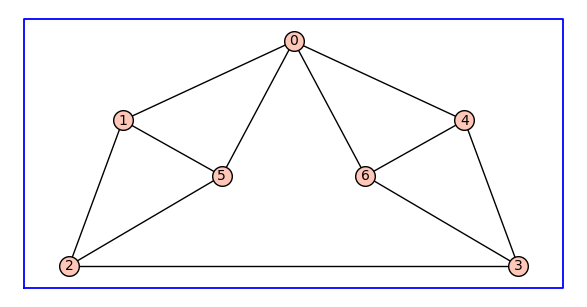

In [233]:
moser = graphs.MoserSpindle()
pos = moser.layout().copy()
print(pos)
pos[2] = [-2.5, -1,6]
pos[3] = [2.5, -1,6]
pos[5] = [-0.8, 0]
pos[6] = [0.8, 0]
pos[0] = [0, 1.5]
p = moser.plot(vertex_labels=True, graph_border=True, pos=pos)
p.show()

In [241]:
degrees_of_freedom(moser)

{(0, 1): 0, (1, 2): 4, (4, 6): 10, (1, 5): 5, (0, 6): 3, (0, 5): 2, (3, 6): 9, (0, 4): 1, (2, 3): 6, (2, 5): 7, (3, 4): 8}


0

In [246]:
def is_laman(g):
    if g.size() != 2 * g.order() - 3:
        return False
    if not is_generic_independent(g):
        return False
    return True

In [247]:
is_laman(moser)

True

In [248]:
moser.size()

11

In [250]:
g.size()

3